In [344]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight')
import os

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score, classification_report, roc_auc_score

from tqdm.notebook import tqdm

In [3]:
df = pd.read_csv('clean_vizathon.csv', index_col=0)

/Users/jared/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
display(df.head(3))
print(df.shape)

,index,game_id,season,day_num,date,team_id,team_name,team_city,team_state,team_dist_from_home,...,opp_blks,opp_pfs,opp_poss,opp_elo_before_game,opp_elo_after_game,opp_elo_win_prob,team_off_eff,team_def_eff,opp_off_eff,opp_def_eff
0,184715,2003_2002-11-14_1104_1328,2003,10,2002-11-14,1328,Oklahoma,Norman,OK,,...,1,22,47,700.0,712.0,0.5,100.000000,109.677419,109.677419,100.000000
1,184714,2003_2002-11-14_1104_1328,2003,10,2002-11-14,1104,Alabama,Tuscaloosa,AL,,...,2,20,48,700.0,688.0,0.5,109.677419,100.000000,100.000000,109.677419
2,161722,2003_2002-11-14_1272_1393,2003,10,2002-11-14,1272,Memphis,Memphis,TN,,...,6,16,64,700.0,688.0,0.5,83.333333,75.000000,75.000000,83.333333


(184940, 58)


In [5]:
df = df.applymap(lambda x:  x.strip() if isinstance(x, str) else x)

#### Note:
Each game is basically duplicated with the two opposing teams each considered once 'team' and once 'opponent'. 

These should be removed.

In [6]:
df.drop_duplicates(subset='game_id',inplace=True)

In [7]:
df.shape

(92470, 58)

Check class balance:

In [446]:
n_samples = df.shape[0]
n_wins = sum(df.team_win)
win_dist = n_wins / n_samples

print("n samples: ", n_samples)
print("n wins: ", n_wins)
print("'win' class distribution: ", round(win_dist, 3))

n samples:  92470
n wins:  46072
'win' class distribution:  0.498


Very even.

### Create a simple logistic regression model.

The baseline accuracy is 70% (simple Elo win probability).

To make statistcal inferences about the model's coefficients, must verify assumptions:
1. Dependent variable(win/lose) is binary. 
2. Observations must be independent of each other (no matched data, e.g. delete duplicate game IDs)
3. Multicollinearity must be small or none  among the independent variables
4. Independent variables are linearly related to the log odds (not to dependent variable)
5. Large enough sample size for number of independent variables considered

In [347]:
# Engineer simple column, 'difference between elo'
df['team_diff_elo'] = df.team_elo_before_game - df.opp_elo_before_game
# preview
df[['team_elo_before_game', 'opp_elo_before_game', 'team_diff_elo']].iloc[200:205]

,team_elo_before_game,opp_elo_before_game,team_diff_elo
398,700.0,688.000000,12.000000
400,700.0,700.000000,0.000000
402,688.0,713.102126,-25.102126
404,688.0,700.000000,-12.000000
407,700.0,712.000000,-12.000000


### Running averages for stats each season

Each season is considered a fresh slate. 

However, if it is the first game of the season, the final average of the previous season is used.

By the second game, the performance from the first game will be the new and only term in the running average.

In [251]:
def rolling_avg_per_season(df, df_grouped, col: str):
    "Return df with column 'avg_{col}' based on the rolling average of df[col] per season"
    gg = df_grouped[col].rolling(window=365, freq='D',min_periods=1).mean().reset_index()
    return df.merge(gg.rename(columns={col: "avg_"+col}))

In [252]:
cols_to_avg = ['team_off_eff', 'team_def_eff', 
                'team_fgm', 'team_3pm', 'team_ftm',
                'team_off_rebs', 'team_def_rebs', 'team_tos']

col_map = {col: "avg_"+col for col in cols_to_avg}
col_include = [v for v in col_map.values()]

In [253]:
df_grouped = df.set_index('game_id').groupby(['team_id', 'season'])

In [254]:
gg = df_grouped[cols_to_avg].rolling(window=2, min_periods=1).mean().shift().reset_index()
gg.rename(columns=col_map, inplace=True)

In [256]:
gg[gg.isnull().any(axis=1)]

,team_id,season,game_id,avg_team_off_eff,avg_team_def_eff,avg_team_fgm,avg_team_3pm,avg_team_ftm,avg_team_off_rebs,avg_team_def_rebs,avg_team_tos
0,1101,2014,2014_2013-11-09_1182_1101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [257]:
df2 = df.merge(gg.dropna(axis=0, how='any'))

In [483]:
columns = col_include + ['team_diff_elo', 'team_elo_win_prob']
X = df2[columns]
y = df2.team_win
X

,avg_team_off_eff,avg_team_def_eff,avg_team_fgm,avg_team_3pm,avg_team_ftm,avg_team_off_rebs,avg_team_def_rebs,avg_team_tos,team_diff_elo,team_elo_win_prob
0,83.603896,84.387352,23.0,4.0,20.0,11.0,23.0,10.0,0.000000,0.500000
1,95.138889,101.157407,23.5,7.0,18.0,15.0,23.5,16.5,0.000000,0.500000
2,79.821429,88.541667,26.0,8.0,5.5,8.0,27.0,16.0,0.000000,0.500000
3,80.922182,76.673660,27.5,8.0,19.5,11.5,30.0,11.5,0.000000,0.500000
4,84.992690,73.669591,25.5,8.5,11.5,9.0,26.5,9.0,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...
92464,80.259870,82.683658,28.5,6.5,8.5,10.0,25.0,10.5,-84.154171,0.215546
92465,81.322537,90.134953,27.0,5.5,11.0,7.5,24.0,15.0,-8.093072,0.468982
92466,83.579545,84.034091,25.5,5.5,13.0,6.0,28.0,13.5,77.378549,0.766348
92467,65.062112,91.713251,24.5,4.0,11.5,11.5,22.5,11.0,-135.668975,0.110800


In [484]:
X.describe()

,avg_team_off_eff,avg_team_def_eff,avg_team_fgm,avg_team_3pm,avg_team_ftm,avg_team_off_rebs,avg_team_def_rebs,avg_team_tos,team_diff_elo,team_elo_win_prob
count,92469.000000,92469.000000,92469.000000,92469.000000,92469.000000,92469.000000,92469.000000,92469.000000,92469.000000,92469.000000
mean,89.698939,89.662875,24.408191,6.622046,14.097725,10.962122,23.786437,13.700797,0.274742,0.500620
std,12.702162,12.897140,3.882093,2.373679,4.691886,3.290650,4.032942,3.395416,107.187132,0.277013
min,38.805970,36.764706,6.000000,0.000000,0.000000,0.000000,8.000000,3.000000,-504.387766,0.000434
25%,81.155633,80.977221,22.000000,5.000000,11.000000,8.500000,21.000000,11.500000,-65.861607,0.266782
50%,88.698439,88.664549,24.000000,6.500000,14.000000,11.000000,23.500000,13.500000,0.000000,0.500000
75%,97.129748,97.192879,27.000000,8.000000,17.000000,13.000000,26.500000,16.000000,66.586779,0.735390
max,192.294372,205.800866,52.000000,22.000000,45.000000,32.000000,48.000000,37.000000,509.305507,0.999598


In [485]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x149b6e978>,
      dtype=object)

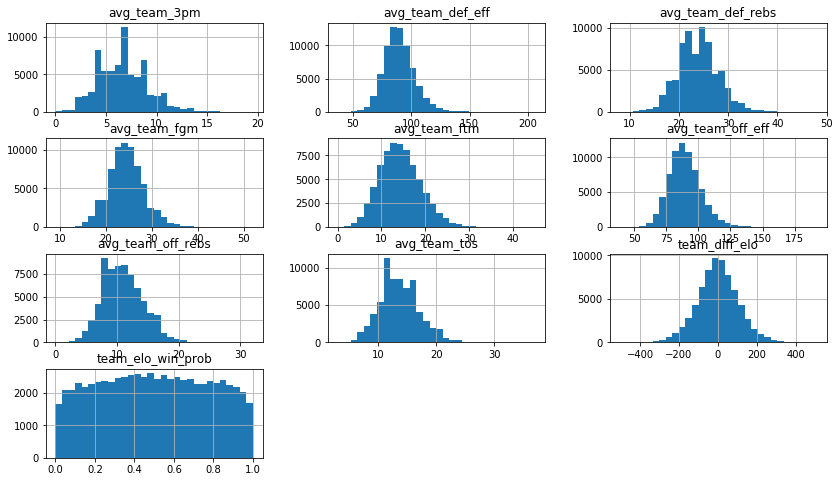

In [486]:
X_train.hist(bins=30, figsize=(14, 8))

In [487]:
LR = LogisticRegression(random_state=10)
LR.fit(X_train, y_train)

y_train_preds = LR.predict(X_train)

In [488]:
print('accuracy_score: ', accuracy_score(y_train, y_train_preds))
print('recall_score: ', recall_score(y_train, y_train_preds))
print('precision_score: ', precision_score(y_train, y_train_preds))

accuracy_score:  0.6988363541982091
recall_score:  0.6944315679684784
precision_score:  0.6986417162177918


Text(0, 0.5, "Difference from Opponent's Elo")

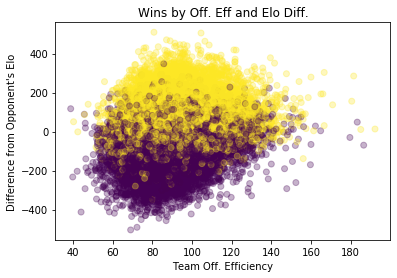

In [489]:
fig, ax = plt.subplots()

ax.scatter(X_train['avg_team_off_eff'], X_train['team_diff_elo'], c=y_train, alpha=.3)
ax.set_title('Wins by Off. Eff and Elo Diff.')
ax.set_xlabel('Team Off. Efficiency')
ax.set_ylabel("Difference from Opponent's Elo")

In [490]:
feat_coef = pd.DataFrame(index=X.columns, data=LR.coef_[0], columns=['LR_coef'])
feat_coef['abs_coef'] = abs(feat_coef['LR_coef'])
feat_coef.sort_values(by='abs_coef', ascending=False)

,LR_coef,abs_coef
avg_team_def_rebs,-0.014408,0.014408
avg_team_off_rebs,0.013089,0.013089
team_diff_elo,0.011780,0.011780
avg_team_fgm,0.008726,0.008726
avg_team_def_eff,-0.004637,0.004637
avg_team_off_eff,0.004147,0.004147
team_elo_win_prob,-0.002099,0.002099
avg_team_tos,0.001870,0.001870
avg_team_ftm,-0.001136,0.001136
avg_team_3pm,0.000922,0.000922


In [491]:
y_pred = LR.predict(X_test)

In [492]:
print('accuracy_score: ', accuracy_score(y_test, y_pred))
print('recall_score: ', recall_score(y_test, y_pred))
print('precision_score: ', precision_score(y_test, y_pred))

accuracy_score:  0.7043861925772126
recall_score:  0.7003288335064036
precision_score:  0.7059490579204466


In [493]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.71      0.71     11562
           1       0.71      0.70      0.70     11556

    accuracy                           0.70     23118
   macro avg       0.70      0.70      0.70     23118
weighted avg       0.70      0.70      0.70     23118



### Trying Multiple Models

In [669]:
### create Elo prediction model

class Elo():
    """
    Make simple Elo predictions from equation
    """
    
    def __init__(self, elo_diff_col='team_diff_elo',
                    team_elo_col='team_elo_before_game', opp_elo_col='opp_elo_before_game'):
        self.elo_diff_col = elo_diff_col
        self.team_elo_col = team_elo_col
        self.opp_elo_col = opp_elo_col
    
    def fit(self, X, y):
        pass
    
    def elo_win_prob(self, elo_diff):
        """
        'elo diff': array
        """
        return 1 / (1 + 10 ** ((elo_diff) / 400))
    
    def predict_proba(self, X_test):
        if not self.elo_diff_col:
            team_elo = X_test[self.team_elo_col]
            opp_elo = X_test[self.opp_elo_col]
            p =  self.elo_win_prob(opp_elo - team_elo).values
        else:
            p = self.elo_win_prob(- X_test[self.elo_diff_col]).values
        return np.array([1-p, p]).T
        
        
    def predict(self, X_test):
        win_probs = self.predict_proba(X_test)[:,1]
        return np.array([1 if x > 0.5 else 0 for x in win_probs])
          

In [670]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
 

In [671]:
def plot_roc(ax, df, name):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label=name)
#     ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('True Positive Rate', fontsize=16)
    ax.set_title('ROC Curve - Model Comparison', fontweight='bold', fontsize=24)
    ax.legend(fontsize=14)

In [672]:
def modelling(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    probs = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, probs)
    thresh_df = calculate_threshold_values(probs, y_test)

    return (precision, recall, accuracy, thresh_df, roc_auc, model)

In [673]:
# initializing models

logistic = LogisticRegression()
gb = GradientBoostingClassifier()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
kn = KNeighborsClassifier()
elo = Elo()
model_list = [logistic, gb, rf, dt, kn, elo]

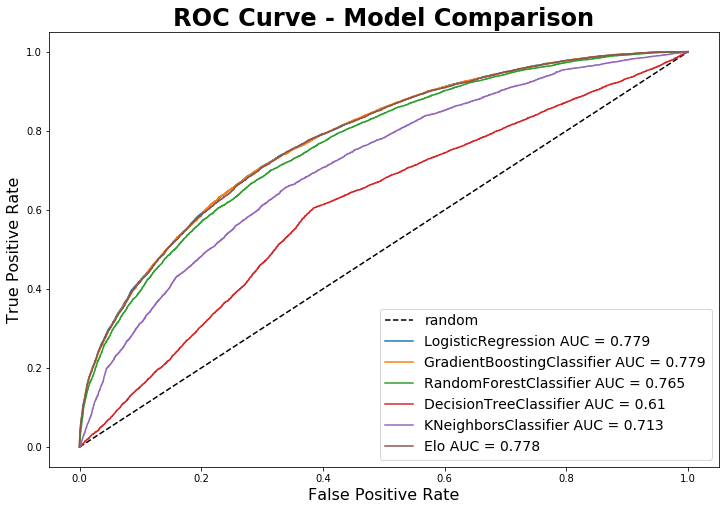

In [681]:
## Fitting and testing models
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([0,1],[0,1], 'k', label="random", linestyle='--')
res_list = []

for model in model_list:
    results = modelling(X_train, X_test, y_train, y_test, model)
    res_list.append(results)
    auc_score = results[4]
    plot_roc(ax, results[3], 
             "{} AUC = {}".format(model.__class__.__name__, round(auc_score, 3)))

In [683]:
res_arr = np.array(res_list)
accuracies = res_arr[:, 2]
for i in range(len(model_list)):
    print(model_list[i].__class__.__name__, " accuracy: ", round(accuracies[i], 4))

LogisticRegression  accuracy:  0.7044
GradientBoostingClassifier  accuracy:  0.7043
RandomForestClassifier  accuracy:  0.6917
DecisionTreeClassifier  accuracy:  0.61
KNeighborsClassifier  accuracy:  0.6589
Elo  accuracy:  0.7037


### Examine Feature importances / Coefficients:

In [684]:
def plot_importances(tree, title):
    """
    tree: a sklearn tree-based model
    """
    importances = tree.feature_importances_
#     std = np.std([t[0].feature_importances_ for t in tree.estimators_],
#                  axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
    # Plot the feature importances of the forest
    plt.figure(figsize=(12,3))
    plt.title(title + ": Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           align="center", alpha=0.7)
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
    print('\n')

#### Feature importances for tree based models

Feature ranking:
1. feature 9 (0.670679)
2. feature 8 (0.304269)
3. feature 0 (0.007071)
4. feature 1 (0.004739)
5. feature 5 (0.003250)
6. feature 2 (0.003049)
7. feature 6 (0.002301)
8. feature 7 (0.001942)
9. feature 4 (0.001605)
10. feature 3 (0.001095)


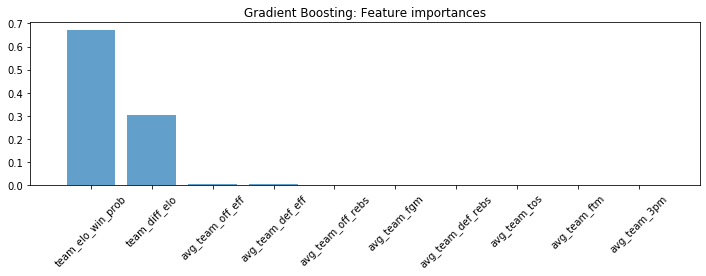



Feature ranking:
1. feature 8 (0.201475)
2. feature 9 (0.189606)
3. feature 0 (0.102797)
4. feature 1 (0.100605)
5. feature 4 (0.074134)
6. feature 5 (0.069251)
7. feature 2 (0.067535)
8. feature 6 (0.066392)
9. feature 7 (0.064997)
10. feature 3 (0.063209)


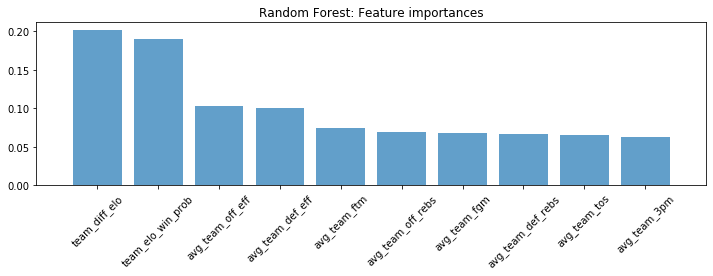



Feature ranking:
1. feature 8 (0.266801)
2. feature 0 (0.114321)
3. feature 1 (0.109334)
4. feature 9 (0.092366)
5. feature 4 (0.077246)
6. feature 2 (0.075708)
7. feature 5 (0.069394)
8. feature 6 (0.067598)
9. feature 7 (0.066124)
10. feature 3 (0.061108)


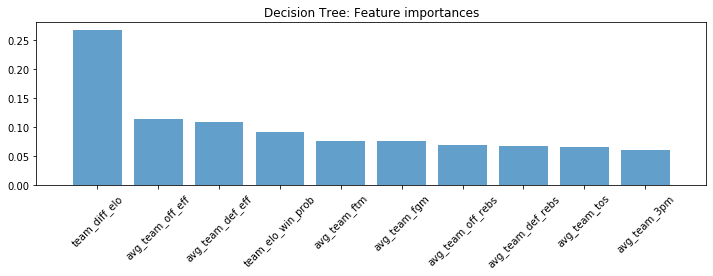

In [685]:
plot_importances(gb, "Gradient Boosting")
plot_importances(rf, "Random Forest")
plot_importances(dt, "Decision Tree")

In [466]:
### Logistic Regression Coefficients

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

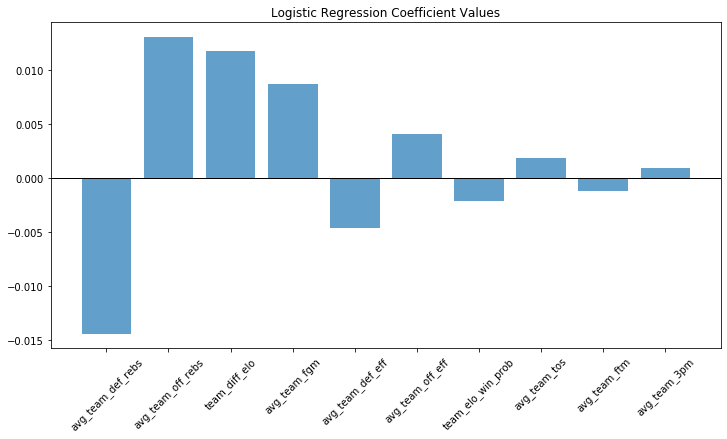

In [686]:
coefs = logistic.coef_[0]
indices = np.argsort(abs(coefs))[::-1]

fig, ax = plt.subplots(figsize=(12,6))

ax.bar(X.columns[indices], coefs[indices], 
      align='center', alpha=0.7)
ax.set_title("Logistic Regression Coefficient Values")
ax.axhline(y=0, color='k', linewidth=1)
plt.xticks(rotation=45)


In [687]:
X.columns[indices]

Index(['avg_team_def_rebs', 'avg_team_off_rebs', 'team_diff_elo',
       'avg_team_fgm', 'avg_team_def_eff', 'avg_team_off_eff',
       'team_elo_win_prob', 'avg_team_tos', 'avg_team_ftm', 'avg_team_3pm'],
      dtype='object')

### Quick Analysis

Tree models generally 



In [391]:
X.columns

Index(['avg_team_off_eff', 'avg_team_def_eff', 'avg_team_fgm', 'avg_team_3pm',
       'avg_team_ftm', 'avg_team_off_rebs', 'avg_team_def_rebs',
       'avg_team_tos', 'team_diff_elo'],
      dtype='object')